#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

##### Imports

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, BaseShuffleSplit, _validate_shuffle_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import f1_score
import scipy.optimize as opt

import math
import cv2
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

##### Create sampling weights

In [4]:
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

weights = create_class_weight(labels_dict)[1]
class_weights = [weights[i] for i in range(28)]
print(class_weights)

[1.0, 3.01, 1.95, 2.79, 2.61, 2.31, 3.23, 2.2, 6.17, 6.34, 6.81, 3.15, 3.61, 3.86, 3.17, 7.1, 3.87, 4.8, 3.34, 2.84, 4.99, 1.91, 3.46, 2.15, 4.37, 1.13, 4.35, 7.74]


In [5]:
# def softmax(x):
#     x = np.array(x)
#     return np.exp(x) / (1 + np.sum(np.exp(x)))

# # class_weights = class_weights / np.sum(class_weights)
# class_weights = softmax(class_weights)
# dict({i:c for i, c in enumerate(class_weights)})

##### Create stratification

In [6]:
def IterativeStratification(labels, r, random_state):
    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)
    c_folds = r * n_samples
    c_folds_labels = np.outer(r, labels.sum(axis=0))
    labels_not_processed_mask = np.ones(n_samples, dtype=bool)
    while np.any(labels_not_processed_mask):
        num_labels = labels[labels_not_processed_mask].sum(axis=0)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break
        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]
        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]
        for sample_idx in sample_idxs:
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]
            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]
                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]
            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds


class MultilabelStratifiedKFold(_BaseKFold):
    def __init__(self, n_splits=3, shuffle=False, random_state=None):
        super(MultilabelStratifiedKFold, self).__init__(n_splits, shuffle, random_state)

    def _make_test_folds(self, X, y):
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(type_of_target_y))

        num_samples = y.shape[0]

        rng = check_random_state(self.random_state)
        indices = np.arange(num_samples)

        if self.shuffle:
            rng.shuffle(indices)
            y = y[indices]

        r = np.asarray([1 / self.n_splits] * self.n_splits)

        test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

        return test_folds[np.argsort(indices)]

    def _iter_test_masks(self, X=None, y=None, groups=None):
        test_folds = self._make_test_folds(X, y)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedKFold, self).split(X, y, groups)

##### Read data

In [7]:
path = Path('data')

In [8]:
train_df = pd.read_csv(path / 'train.csv')

In [9]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


##### Split data with Stratification and use first split

In [10]:
y = np.array(train_df.Target.str.split(' '))
y = [[int(k) for k in lst] for lst in y]
y[:5]

[[16, 0], [7, 1, 2, 0], [5], [1], [18]]

In [11]:
mlb = MultiLabelBinarizer()
y_onehot = mlb.fit_transform(y)
mlb.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [12]:
msfk = MultilabelStratifiedKFold(5, random_state=42)
x = np.zeros((31072, 31072))
trn_idx, tst_idx = None, None
for trn, tst in msfk.split(x, y_onehot):
    trn_idx = trn
    tst_idx = tst

In [13]:
len(trn_idx), len(tst_idx)

(24812, 6260)

##### Create model

In [14]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [15]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [16]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [17]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [18]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [19]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [20]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [21]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [22]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [23]:
src.add_test(test_fnames, label='0');

In [24]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [25]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [26]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.05, max_lighting=0.05, max_warp=0.05,
                            xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2)), squish(scale=0.83)])

In [27]:
def get_sample_weights(labels, weight_per_class):
    sample_weights = [np.max(np.array(weight_per_class)[np.nonzero(lab)[0]]) for lab in labels]
    return sample_weights

# sample_weights = get_sample_weights(np.array(train_df.Target.str.split(' ')), np.array(class_weights))

sample_weights = get_sample_weights(np.array(train_df.iloc[trn_idx].Target.str.split(' ')), np.array(class_weights))
sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(sample_weights)) 

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

In [29]:
tmp = data.dl(DatasetType.Train)
tmp

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5c29de4780>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f5e1373c510>, mean=tensor([0.0807, 0.0526, 0.0549, 0.0828]), std=tensor([0.1370, 0.1015, 0.1531, 0.1381]), do_y=None)], collate_fn=<function data_collate at 0x7f5e1a620488>, skip_size1=True)

In [30]:
tmp2 = DeviceDataLoader.create(data.train_ds, bs=16, shuffle=False, device=torch.device('cuda'), sampler=sampler, tfms=tmp.tfms)
tmp2

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5c29de4080>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f5e1373c510>, mean=tensor([0.0807, 0.0526, 0.0549, 0.0828]), std=tensor([0.1370, 0.1015, 0.1531, 0.1381]), do_y=None)], collate_fn=<function data_collate at 0x7f5e1a620488>, skip_size1=False)

In [31]:
data.train_dl = tmp2

In [32]:
data.dl(DatasetType.Train)

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5c29de4080>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f5e1373c510>, mean=tensor([0.0807, 0.0526, 0.0549, 0.0828]), std=tensor([0.1370, 0.1015, 0.1531, 0.1381]), do_y=None)], collate_fn=<function data_collate at 0x7f5e1a620488>, skip_size1=False)

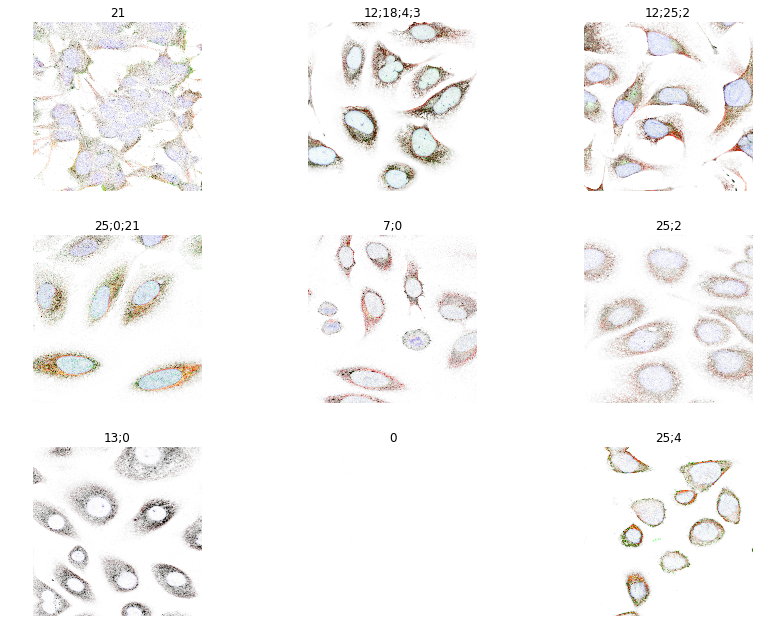

In [33]:
data.show_batch(rows=3, figsize=(12,9))

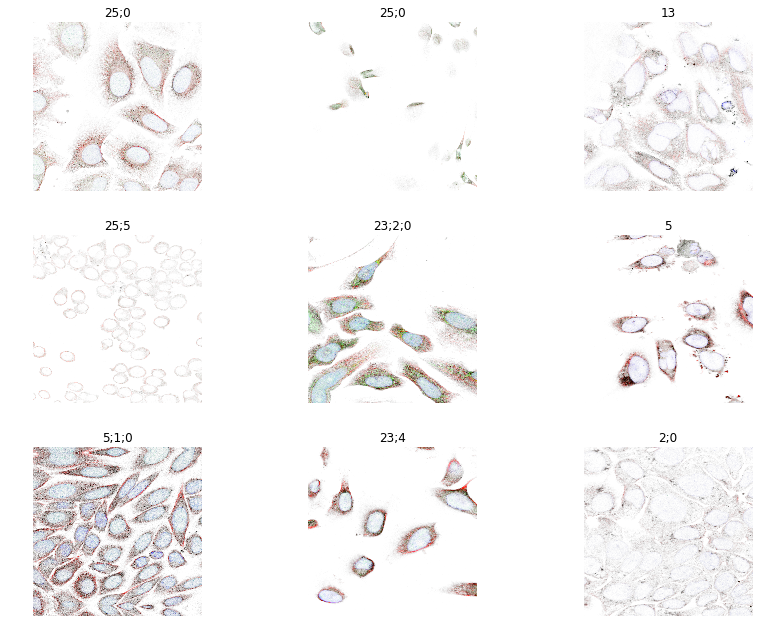

In [34]:
data.show_batch(rows=3, figsize=(12,9))

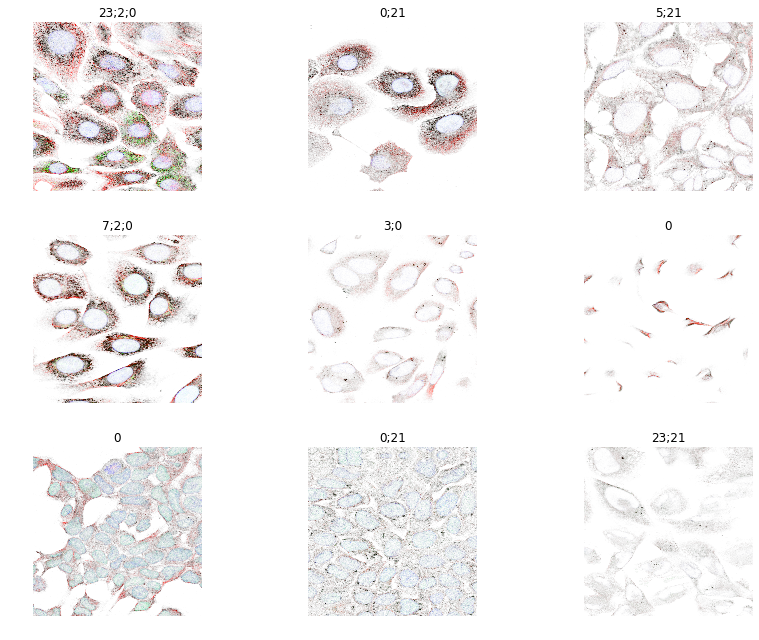

In [35]:
data.show_batch(rows=3, figsize=(12,9))

In [36]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [37]:
def _resnet_split(m): return (m[0][6],m[1])

In [38]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [39]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score],
    ps=0.7
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


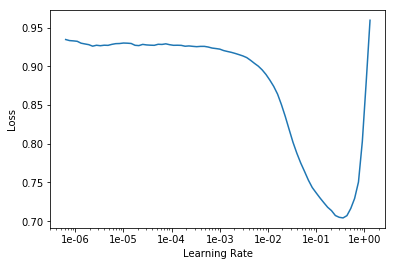

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(4, 1e-2, wd=0.1)

Total time: 19:23
epoch  train_loss  valid_loss  fbeta   
1      0.156429    0.150364    0.470911  (05:06)
2      0.143935    0.142236    0.467340  (04:46)
3      0.130380    0.112981    0.592102  (04:44)
4      0.123565    0.105203    0.618454  (04:45)



In [41]:
learn.fit_one_cycle(8, slice(1e-2), wd=0.1)

Total time: 38:14
epoch  train_loss  valid_loss  fbeta   
1      0.124722    0.106072    0.613160  (04:49)
2      0.126947    0.118295    0.579456  (04:47)
3      0.129867    0.119525    0.558519  (04:46)
4      0.126516    0.119300    0.564668  (04:45)
5      0.122632    0.109935    0.602545  (04:46)
6      0.115488    0.100670    0.631196  (04:47)
7      0.116526    0.099240    0.637005  (04:46)
8      0.111316    0.098376    0.641756  (04:44)



In [42]:
learn.save("resnet50-224-weighted-sampling")

In [39]:
_ = learn.load("resnet50-224-weighted-sampling")

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


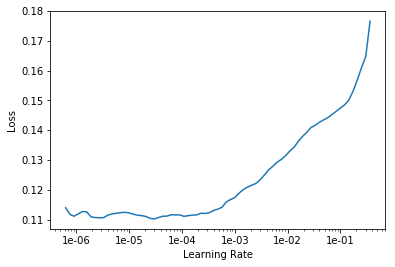

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4), wd=0.1)

Total time: 40:05
epoch  train_loss  valid_loss  fbeta   
1      0.112952    0.098244    0.642631  (05:07)
2      0.109911    0.098139    0.644161  (05:01)
3      0.109462    0.098445    0.641862  (05:00)
4      0.109104    0.096772    0.647956  (05:02)
5      0.108785    0.096016    0.650027  (04:59)
6      0.106991    0.096630    0.647409  (04:57)
7      0.107448    0.095982    0.648591  (04:58)
8      0.107528    0.096068    0.649567  (04:58)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


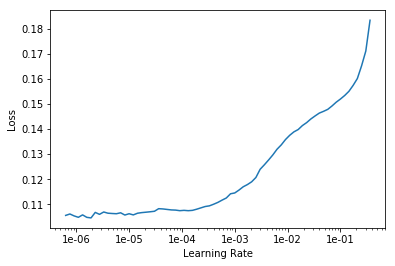

In [43]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(12, slice(1e-8, 1e-6), wd=0.1)

epoch,train_loss,valid_loss,fbeta
1,0.107743,0.095980,0.650314
2,0.107279,0.095663,0.651372
3,0.107412,0.096129,0.650440
4,0.106409,0.096133,0.648065
5,0.109666,0.095651,0.651205
6,0.107704,0.096072,0.649409
7,0.106255,0.096111,0.650104
8,0.107888,0.096096,0.648434
9,0.106062,0.096182,0.648919
10,0.107580,0.095551,0.651392


In [45]:
learn.save("resnet50-224-weighted-sampling-unfreeze")

In [39]:
_ = learn.load("resnet50-224-weighted-sampling-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


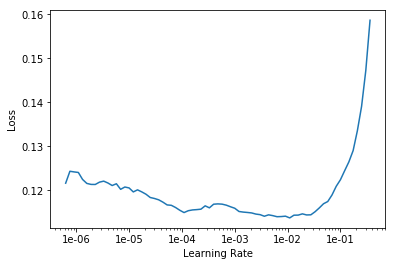

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(10, 1e-2, wd=0.15)

Total time: 1:21:21
epoch  train_loss  valid_loss  fbeta   
1      0.113115    0.097012    0.647906  (08:27)
2      0.125986    0.118371    0.573080  (08:09)
3      0.137389    0.148994    0.482679  (08:04)
4      0.137814    0.138977    0.524298  (08:07)
5      0.136850    0.133218    0.499298  (08:04)
6      0.136776    0.149090    0.490374  (08:06)
7      0.127028    0.106541    0.616842  (08:05)
8      0.117724    0.101305    0.629834  (08:06)
9      0.111898    0.094461    0.656130  (08:05)
10     0.110529    0.092417    0.667247  (08:05)



In [42]:
learn.save("resnet50-384-weighted-sampling")

In [43]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-384-weighted-sampling-avg_pred.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-384-weighted-sampling-preds_v1.csv', header=True, index=False)
df.head()

Total time: 30:15



In [39]:
_ = learn.load("resnet50-384-weighted-sampling")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


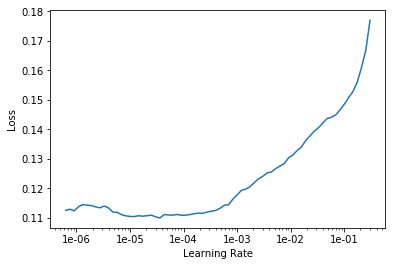

In [46]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(1e-6, 1e-4), wd=0.15)

epoch,train_loss,valid_loss,fbeta
1,0.112154,0.092404,0.661975
2,0.111156,0.092410,0.665923
3,0.110675,0.091377,0.669439
4,0.109239,0.091913,0.666161


In [ ]:
# With above close to 0.67 febta
learn.save("resnet50-384-weighted-sampling-unfreeze")

In [40]:
_ = learn.load("resnet50-384-weighted-sampling-unfreeze")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


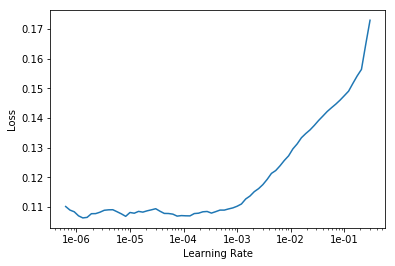

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(12, slice(1e-8, 5e-5), wd=0.2)

Total time: 1:42:07
epoch  train_loss  valid_loss  fbeta   
1      0.106574    0.089895    0.673208  (08:44)
2      0.106004    0.089909    0.672212  (08:30)
3      0.107374    0.089585    0.675272  (08:27)
4      0.107746    0.090008    0.673616  (08:29)
5      0.105539    0.089707    0.674115  (08:29)
6      0.105960    0.089528    0.676313  (08:29)
7      0.103737    0.089834    0.676983  (08:28)
8      0.106795    0.089442    0.676735  (08:28)
9      0.106971    0.089904    0.673454  (08:29)
10     0.104954    0.089783    0.676116  (08:29)
11     0.107351    0.089396    0.678643  (08:28)
12     0.104813    0.089509    0.673365  (08:31)



In [43]:
learn.save("resnet50-384-weighted-sampling-unfreeze")

In [44]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-384-weighted-sampling-avg_pred-unfreeze.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-384-weighted-sampling-preds_v1-unfreeze.csv', header=True, index=False)
df.head()

Total time: 30:26



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 7 21 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25


In [39]:
_ = learn.load("resnet50-384-weighted-sampling-unfreeze") 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


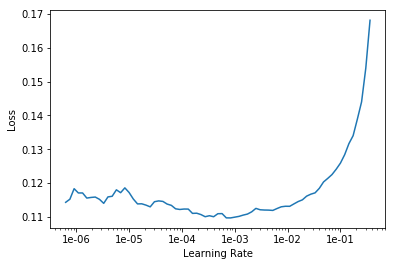

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(12, 5e-4, wd=0.2)

Total time: 2:25:31
epoch  train_loss  valid_loss  fbeta   
1      0.107972    0.095143    0.651319  (12:28)
2      0.106981    0.093285    0.660839  (12:08)
3      0.105860    0.093311    0.655043  (12:05)
4      0.106976    0.091150    0.666844  (12:01)
5      0.107200    0.092230    0.664399  (12:01)
6      0.109471    0.091208    0.666861  (12:05)
7      0.106322    0.090414    0.671387  (12:03)
8      0.105190    0.090314    0.667861  (12:04)
9      0.105099    0.088822    0.676558  (12:04)
10     0.104033    0.087505    0.680689  (12:03)
11     0.103328    0.087945    0.679437  (12:02)
12     0.103298    0.088253    0.675222  (12:21)



In [42]:
learn.save("resnet50-512-weighted-sampling")

In [43]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-avg_pred.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-preds_v1.csv', header=True, index=False)
df.head()

Total time: 51:27



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,3 5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [40]:
_ = learn.load("resnet50-512-weighted-sampling")

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


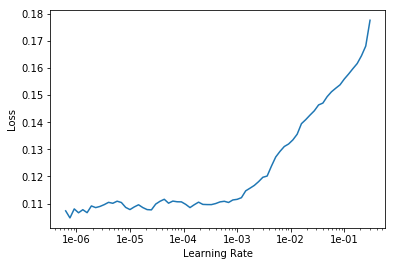

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(12, slice(1e-7, 5e-6), wd=0.2)

Total time: 2:53:55
epoch  train_loss  valid_loss  fbeta   
1      0.101647    0.087051    0.685302  (15:11)
2      0.107668    0.088104    0.679891  (14:49)
3      0.107021    0.088751    0.677579  (14:10)
4      0.104558    0.088269    0.677935  (12:46)
5      0.106781    0.088962    0.675074  (12:58)
6      0.109868    0.088522    0.677566  (14:49)
7      0.107841    0.088197    0.679041  (14:52)
8      0.107852    0.088410    0.680759  (14:52)
9      0.103720    0.088030    0.679022  (14:50)
10     0.105483    0.087140    0.686818  (14:53)
11     0.104750    0.088311    0.675372  (14:49)
12     0.106437    0.089087    0.677905  (14:50)



In [44]:
learn.save("resnet50-512-weighted-sampling-unfreeze")

In [45]:
learn.fit_one_cycle(20, slice(1e-8, 5e-5), wd=0.15)

Total time: 4:53:16
epoch  train_loss  valid_loss  fbeta   
1      0.106037    0.088500    0.677329  (14:54)
2      0.107231    0.087872    0.682267  (14:44)
3      0.108115    0.088361    0.676256  (14:51)
4      0.102837    0.087628    0.681430  (14:50)
5      0.104485    0.087796    0.681936  (14:57)
6      0.104196    0.088112    0.678792  (14:51)
7      0.105019    0.086807    0.685356  (14:54)
8      0.106186    0.087376    0.681970  (14:55)
9      0.103589    0.088051    0.677274  (14:54)
10     0.106418    0.087224    0.683027  (14:55)
11     0.107220    0.087616    0.682353  (14:56)
12     0.104366    0.087757    0.681352  (14:52)
13     0.106699    0.088399    0.678594  (14:55)
14     0.106238    0.087840    0.679138  (14:48)
15     0.104207    0.087234    0.683994  (14:51)
16     0.103313    0.087268    0.683021  (14:54)
17     0.105341    0.087463    0.684880  (14:57)
18     0.105494    0.087839    0.680274  (14:31)
19     0.104498    0.087221    0.683248  (12:48)
20     0.

In [46]:
learn.save("resnet50-512-weighted-sampling-unfreeze")

In [40]:
_ = learn.load("resnet50-512-weighted-sampling-unfreeze")

In [41]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-avg_pred-unfreeze-0.2.csv', header=True, index=False)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-preds_v1-unfreeze-0.2.csv', header=True, index=False)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.5)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-avg_pred-unfreeze-0.5.csv', header=True, index=False)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.5)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50-512-weighted-sampling-preds_v1-unfreeze-0.5.csv', header=True, index=False)

Total time: 56:00

